<a href="https://colab.research.google.com/github/Alexandre77777/neural_networks/blob/main/6.%20%D0%90%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80%D1%8B/%D0%A2%D0%B5%D0%BC%D0%B0_%E2%84%966_%D0%90%D0%B2%D1%82%D0%BE%D1%8D%D0%BD%D0%BA%D0%BE%D0%B4%D0%B5%D1%80%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Тема №6. Автоэнкодер**

# Автоэнкодер

В самом простом варианте автоэнкодер – это НС, которая сначала кодирует входной сигнал в некоторое скрытое состояние, размерность которого, как правило, меньше размерности входного сигнала, а затем, из скрытого состояния снова разворачивает (декодирует) данные в другое, новое состояние:

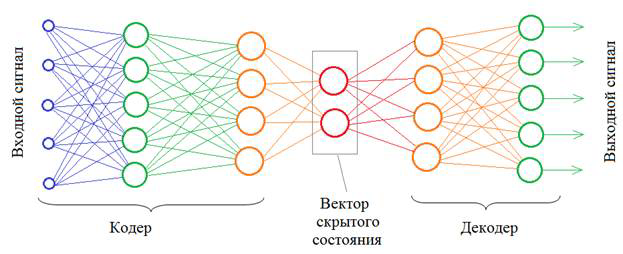

Размерности входных и выходных векторов, в общем случае, могут отличаться. Например, можно попробовать обучить автоэнкодер масштабировать изображения. В другом примере, сжатия данных, декодер должен как можно точнее воспроизвести входное изображение, опираясь только на вектор скрытого состояния. Сам же этот вектор будет представлять сжатое изображение. Правда, НС в области сжатия работают хуже традиционных алгоритмов, поэтому автоэнкодеры нашли свое применение в других областях.

## Основные операции

### Для **кодирования** входных данных можно применять все те операции, которые мы использовали ранее (слои Dense(), Flatten(), Conv2D(), MaxPooling2D() и т.д.)

> При кодировке изображений хоршей практикой является использование предобученных моделей, основанных на архитеркурах ResNet, VGG и др.



### Для **декодирования** свёрточных слоев в основном используются операции Upsampling (слой [UpSampling2D](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/)),  и Deconvolution (слой [Conv2DTranspose](https://keras.io/api/layers/reshaping_layers/up_sampling2d/))

Операция **Upsampling** является своеобразной инверсией операции **Pooling**, а операция **Deconvolution** является инверсией операции **Convolution**.

> Соответственно, для кодирования входных данных мы используем слои Conv2D и Pooling, а для декодирования Conv2DTranspose и UpSampling2D.

[Более подробная информация о принципах работы](https://github.com/christianversloot/machine-learning-articles/blob/main/upsampling2d-how-to-use-upsampling-with-keras.md)

## Принцип работы алгоритма [Deconvolution](https://github.com/vdumoulin/conv_arithmetic):

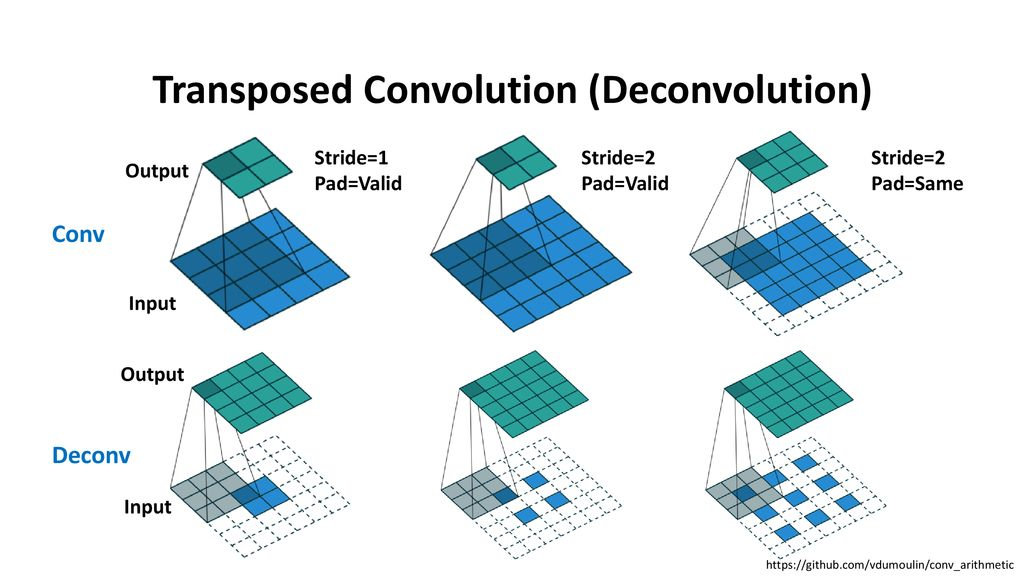

## Принцип работы алгоритма Upsampling

### Общий принцип:




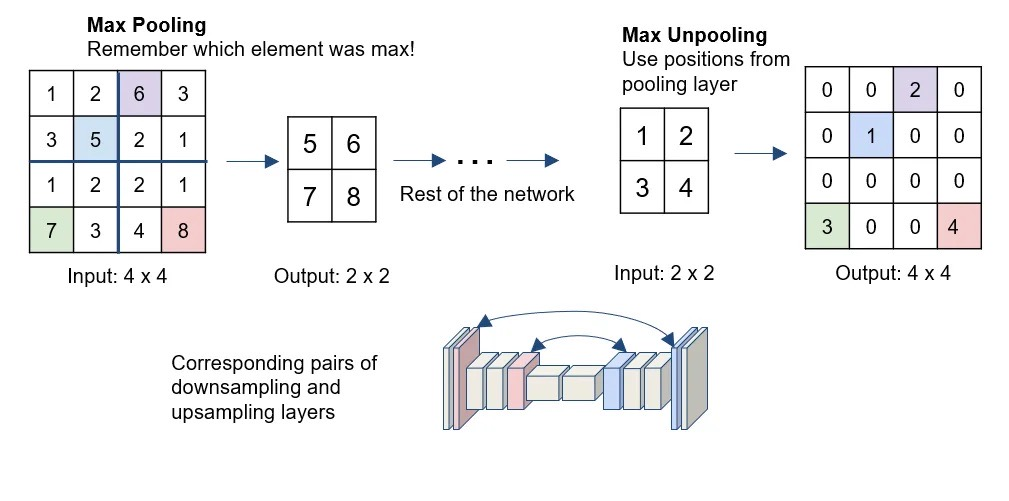

### C параметрами интерполяции по умолчанию в Keras (ближайший сосед):


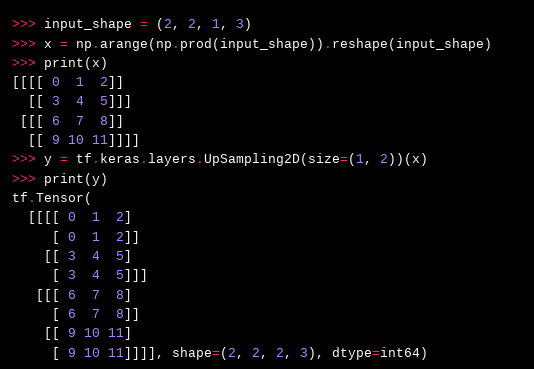

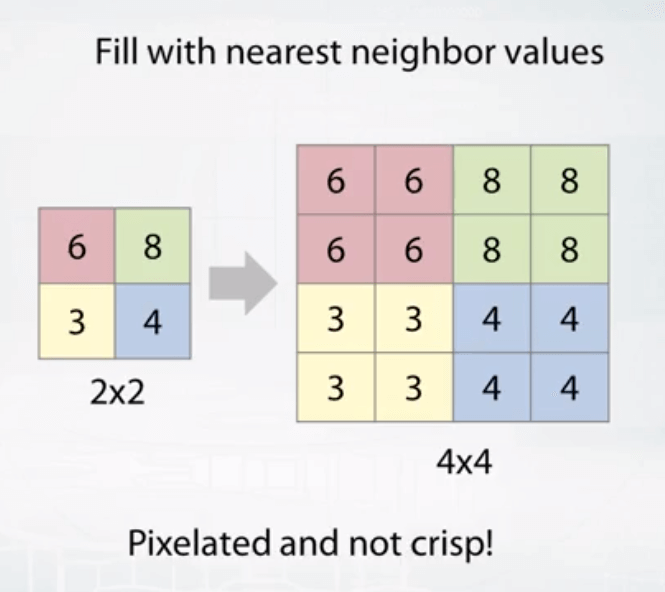

Все типы интерполяции в Keras: "area", "bicubic", "bilinear", "gaussian", "lanczos3", "lanczos5", "mitchellcubic", "nearest".

## Пример декодирования изображения используя операцию UpSampling:



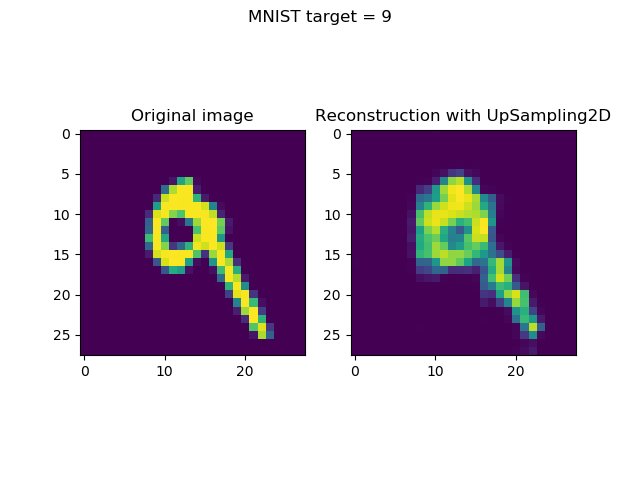

## Пример декодирования изображения используя операцию Deconvolution:



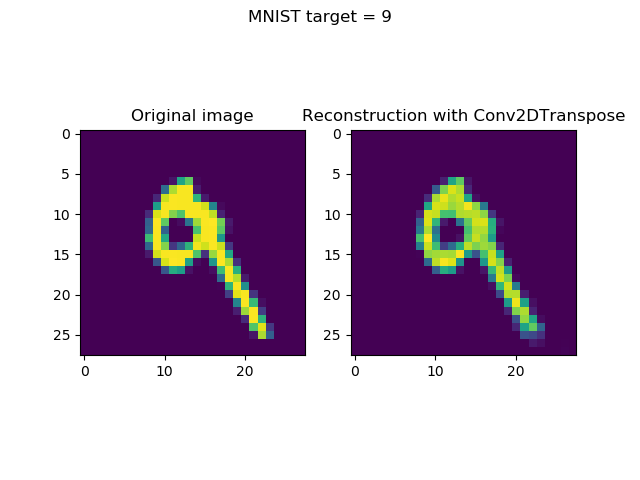

# Пример 1. Базовая модель автоэнкодера

Источник: https://keras.io/examples/vision/autoencoder/

## Установка зависимостей и написание функций для обработки данных

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.

    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Добавляет случайный шум к каждому изображению в предоставленном массиве.

    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Отображает десять случайных изображений из каждого из предоставленных массивов.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

## Подготовка данных

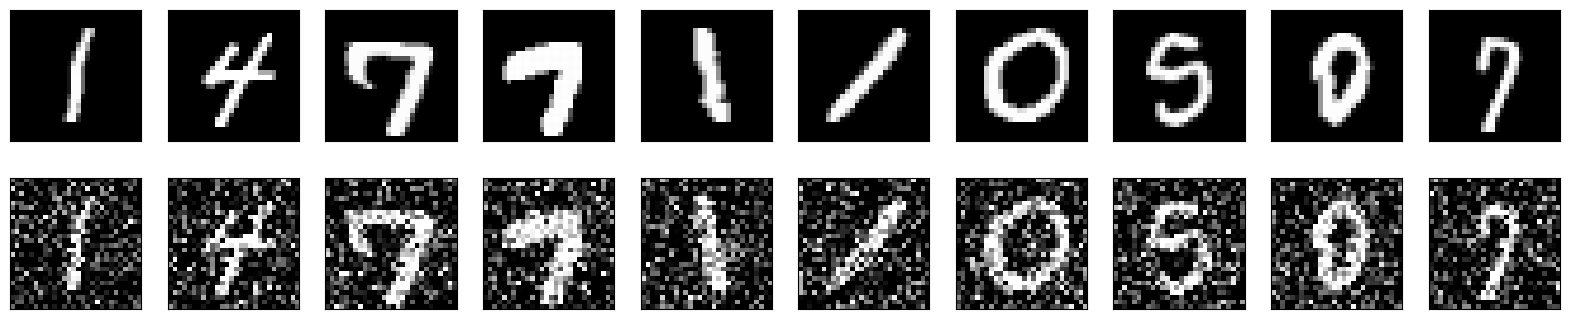

In [ ]:
# Поскольку для кодирования и декодирования нам нужны только изображения из набора данных, мы
# не будем использовать метки классов
(train_data, _), (test_data, _) = mnist.load_data()

# Нормализация и изменение формы данных
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Создание копии данных с добавленным шумом
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Отображение данных выборки и его версии с добавленным шумом
display(train_data, noisy_train_data)

## Построение автоэнкодера

- В автоэнкодере используется сигмоидальная функция активации в последнем слое декодера, потому что она ограничивает выходные значения в диапазоне от 0 до 1. Это особенно полезно, когда автоэнкодер работает с изображениями, где пиксели нормализованы к этому диапазону. Сигмоидальная функция активации обеспечивает то, что выходные данные модели могут быть интерпретированы как вероятности, что делает её идеальной для задач, где выходные данные являются бинарными (в случае с классификацией) или находятся между 0 и 1.

- Функция потерь `binary_crossentropy` используется в сочетании с сигмоидальной функцией активации, потому что она измеряет "расстояние" между двумя распределениями вероятностей - предсказанным и истинным. В контексте автоэнкодеров, которые часто используются для восстановления входных данных после сжатия, `binary_crossentropy` подходит для измерения различий между исходными и восстановленными изображениями.

In [ ]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       9248  

> Теперь мы можем обучить наш автоэнкодер, используя train_data как входные и целевые данные одновременно. Обратите внимание, что мы настраиваем данные для проверки, используя тот же формат.Наш автоэнкодер сжимает, а затем восстанавливает исходные изображения из софрмировавшихся карт призкаков.

In [ ]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/50
469/469 [==============================] - 14s 9ms/step - loss: 0.1342 - val_loss: 0.0738
Epoch 2/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0722 - val_loss: 0.0700
Epoch 3/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0698 - val_loss: 0.0685
Epoch 4/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0687 - val_loss: 0.0677
Epoch 5/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0679 - val_loss: 0.0670
Epoch 6/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0673 - val_loss: 0.0666
Epoch 7/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0668 - val_loss: 0.0661
Epoch 8/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0663 - val_loss: 0.0657
Epoch 9/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0660 - val_loss: 0.0654
Epoch 10/50
469/469 [==============================] - 4s 9ms/step - loss: 0.0657 - val_loss: 0.065

> Давайте предскажем на нашем тестовом наборе данных и покажем оригинальное изображение вместе с предсказанием нашего автоэнкодера.

* Обратите внимание, что предсказания довольно близки к исходным изображениям, хотя и не совсем одинаковы.

313/313 [==============================] - 1s 2ms/step


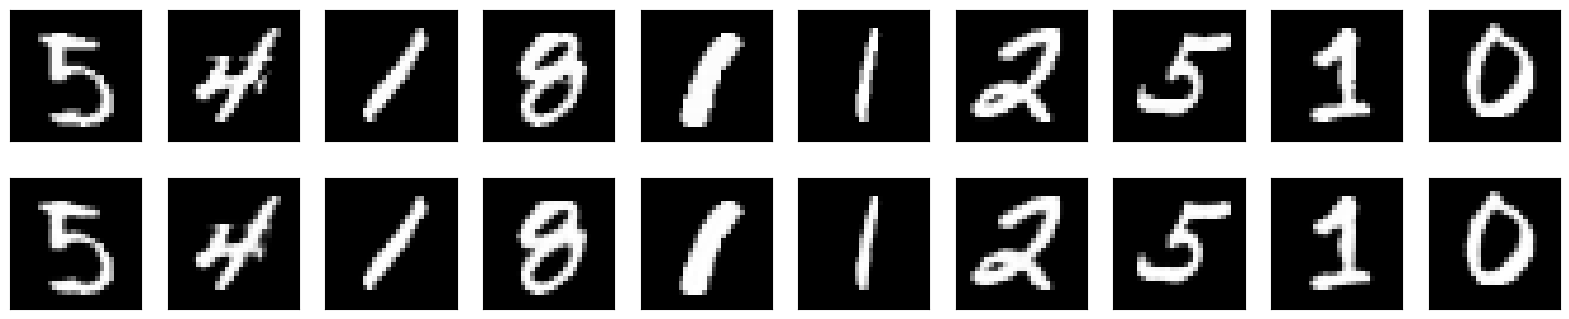

In [ ]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

# Пример 2. Использование автоэнкодера для удаления шума на изображении

* Теперь, когда мы знаем, что наш автоэнкодер работает, давайте переучим его, используя зашумленные данные в качестве входных и чистые данные в качестве целевых. Мы хотим, чтобы наш автоэнкодер научился удалять шум на изображениях.

In [ ]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=100,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/100
469/469 [==============================] - 4s 9ms/step - loss: 0.1004 - val_loss: 0.0932
Epoch 2/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0927 - val_loss: 0.0910
Epoch 3/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0910 - val_loss: 0.0900
Epoch 4/100
469/469 [==============================] - 4s 9ms/step - loss: 0.0900 - val_loss: 0.0889
Epoch 5/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0893 - val_loss: 0.0884
Epoch 6/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0888 - val_loss: 0.0879
Epoch 7/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0884 - val_loss: 0.0877
Epoch 8/100
469/469 [==============================] - 5s 10ms/step - loss: 0.0880 - val_loss: 0.0872
Epoch 9/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0876 - val_loss: 0.0869
Epoch 10/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0874 - val_l

313/313 [==============================] - 1s 2ms/step


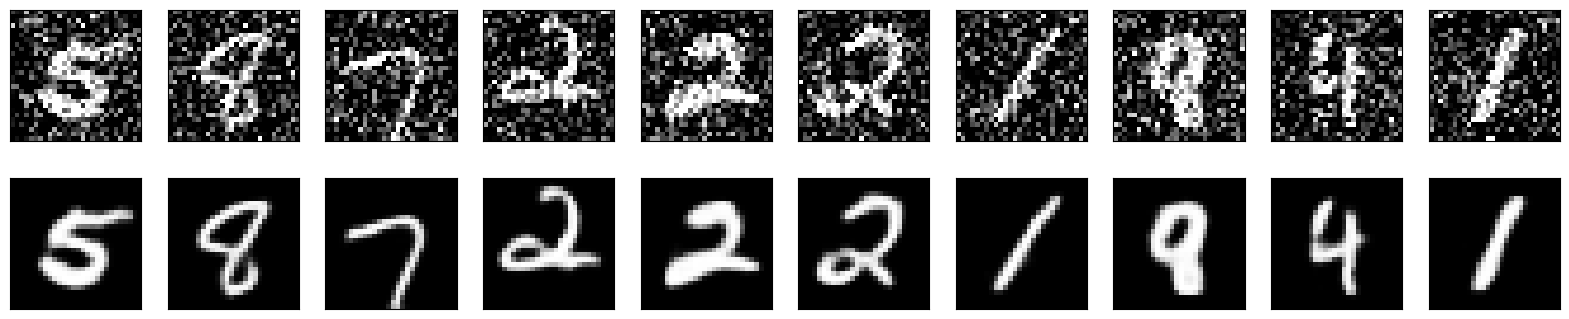

In [ ]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

# Пример 3. Использование автоэнкодера для колоризации изображений

In [ ]:
from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb, rgb2gray
from skimage.transform import resize
from skimage.io import imsave
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import keras
import cv2
import os

> * В качестве кодировщика используем предобученную модель с архитектурой VGG16.
Кодировщик не нужен нам как классификатор, мы используем его для извлечения признаков, поэтому, последние полносвязные слои нам не нужны, мы должны их убрать.

> * Для этого мы итерируем каждый слой, кроме последних полносвязных слоев,
мы добавляем 19 слоёв в нашу модель, размерность последнего слоя - "7x7x512".

> * Мы будем использовать его в качестве карты признаков для ввода в декодер.

In [ ]:
from keras.applications.vgg16 import VGG16
vggmodel = VGG16() # Импортируем предобученную модель VGG16 с параметрами по умолчанию
newmodel = Sequential() # Создаём пустую модель

for i, layer in enumerate(vggmodel.layers): # Заполняем пустую модель слоями из предобученной модели VGG16
    if i<19:          # Только до 19-го слоя, чтобы включить только слои, используемые для извлечения признаков
      newmodel.add(layer)

newmodel.summary()

553467096/553467096 [==============================] - 16s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                      

> * Мы хотим использовать слои VGG16 с их оригинальными весами, не изменяя их, поэтому мы установим параметр обучаемости в каждом слое равный false, потому что мы не хотим обучать их снова.

In [ ]:
for layer in newmodel.layers:
  layer.trainable=False   # Мы не хотим снова обучать эти слои, поэтому False.

> * VGG16 ожидает на вход трехмерное изображение с размерностью (224,224)
при предварительной обработке мы должны масштабировать все изображения до 224

Для формирования обучающей выборки используем [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [ ]:
Общий синтаксис: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)
# test_datagen = ImageDataGenerator(rescale=1./255)
# train_generator = train_datagen.flow_from_directory(
#         'data/train',
#         target_size=(150, 150),
#         batch_size=32,
#         class_mode='binary')
# validation_generator = test_datagen.flow_from_directory(
#         'data/validation',
#         target_size=(150, 150),
#         batch_size=32,
#         class_mode='binary')
# model.fit(
#         train_generator,
#         steps_per_epoch=2000,
#         epochs=50,
#         validation_data=validation_generator,
#         validation_steps=800)

In [ ]:
path = '/content/drive/MyDrive/Dataset/'

train_datagen = ImageDataGenerator(rescale=1. / 255)
train = train_datagen.flow_from_directory(path, target_size=(224, 224), batch_size=100, class_mode=None)

print(train)

Found 2595 images belonging to 2 classes.


> * Затем, мы преобразуем каждое изображение из цветовой палитры RGB в Lab.
Изображение [LAB](https://ru.wikipedia.org/wiki/LAB) - это изображение, представленное в оттенках серого в канале L, а вся информация о цвете хранится в каналах A и B.

> * Входом для сети будет канал L, поэтому мы помещаем его в массив X.
В массив Y поместим каналы A и B.

In [ ]:
print(train[0].shape)

(100, 224, 224, 3)


In [ ]:
X =[]
Y =[]

for img in train:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0])
      Y.append(lab[:,:,1:] / 128) # Значения A и B находятся в диапазоне от -127 до 128,
      # поэтому мы делим значения на 128, чтобы ограничить значения от -1 до 1.
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #размерности должны быть одинаковыми для X и Y
print(X.shape)
print(Y.shape)
print(train[0].shape)

(100, 224, 224, 1)
(100, 224, 224, 2)
(100, 224, 224, 3)


> * В каждый входной слой мы поместили канал L, но VGG16 ожидает 3 канала,поэтому мы повторили канал L два раза, чтобы получить размерность (224,224,3)

In [ ]:
# Создается пустой список для хранения признаков, извлеченных с помощью VGG
vggfeatures = []

# Перебираются образцы в наборе данных X
for i, sample in enumerate(X):
  # Конвертируется одноканальное изображение в трехканальное (RGB)
  sample = gray2rgb(sample)
  # Изменяется форма образца для соответствия входу сети VGG16
  sample = sample.reshape((1,224,224,3))
  # Производится предварительная обработка образца для сети VGG16
  sample = keras.applications.vgg16.preprocess_input(sample)
  # Получается предсказание модели для обработанного образца
  prediction = newmodel.predict(sample)
  # Изменяется форма предсказания для соответствия выходу сети VGG16
  prediction = prediction.reshape((7,7,512))
  # Добавляется предсказание в список признаков
  vggfeatures.append(prediction)

# Преобразуется список признаков в NumPy массив
vggfeatures = np.array(vggfeatures)
# Выводится форма массива признаков
print(vggfeatures.shape)

1/1 [==============================] - 0s 22ms/step
(100, 7, 7, 512)


In [ ]:
#Decoder
model = Sequential()

model.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(7,7,512)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.summary()


model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_43 (Conv2D)          (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d_35 (UpSamplin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_36 (UpSamplin  (None, 28, 28, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 28, 28, 32)       

In [ ]:
model.fit(vggfeatures, Y, verbose=1, epochs=1000, batch_size=256)

model.save('/content/colorize_autoencoder_VGG16.h5')

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 0.6713 - accuracy: 0.6709
Epoch 2/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.9990 - accuracy: 0.2969
Epoch 3/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.8924 - accuracy: 0.3004
Epoch 4/1000
1/1 [==============================] - 0s 74ms/step - loss: 0.8886 - accuracy: 0.3030
Epoch 5/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.8605 - accuracy: 0.3003
Epoch 6/1000
1/1 [==============================] - 0s 67ms/step - loss: 0.8044 - accuracy: 0.3386
Epoch 7/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.9200 - accuracy: 0.3099
Epoch 8/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.7634 - accuracy: 0.3591
Epoch 9/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.8055 - accuracy: 0.6744
Epoch 10/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.8294 - accuracy: 0.5288
Epoch 11/10

In [ ]:
model = tf.keras.models.load_model('/content/colorize_autoencoder_VGG16.h5',
                                   custom_objects=None,
                                   compile=True)

Тестирование обученной модели на пользовательских данных

(Лучше всего написать для этого отдельную функцию)

In [ ]:
# Задается путь к изображениям для обработки
testpath = '/content/drive/MyDrive/Dataset/Train/Cats/'

# Получается список файлов в указанной директории
files = os.listdir(testpath)

# Перебираются файлы в директории
for idx, file in enumerate(files):
    # Изображение преобразуется в массив и нормализуется
    test = img_to_array(load_img(testpath+file))
    test = resize(test, (224,224), anti_aliasing=True)
    test *= 1.0/255

    # Изображение конвертируется из RGB в Lab
    lab = rgb2lab(test)
    l = lab[:,:,0]

    # Канал L преобразуется обратно в RGB
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))

    # Изображение подготавливается для модели VGG16
    L = keras.applications.vgg16.preprocess_input(L)

    # Получается предсказание модели для канала L
    vggpred = newmodel.predict(L)
    ab = model.predict(vggpred)

    # Каналы a и b умножаются на 128 для преобразования обратно в цветовое пространство LAB
    ab = ab*128

    # Создается новое изображение с каналами L, a и b
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab

    # Изображение сохраняется на диск
    imsave('/content/'+str(idx)+".jpg", lab2rgb(cur))


Вывод результатов:

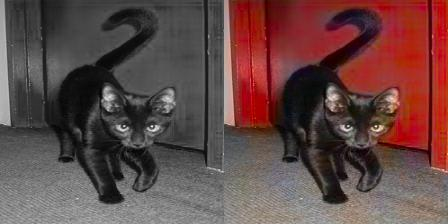

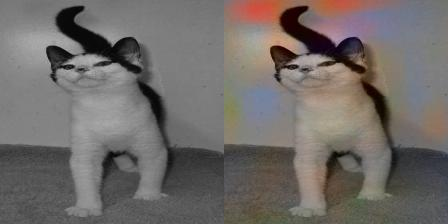

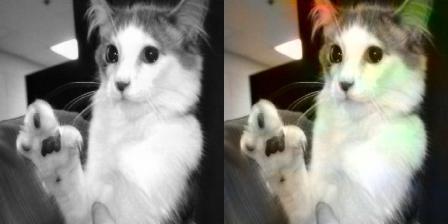

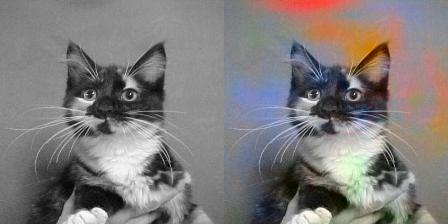

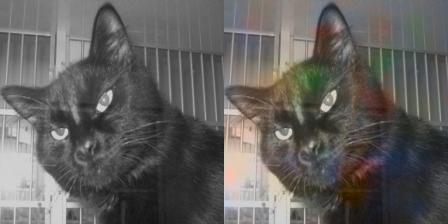

In [ ]:
from google.colab.patches import cv2_imshow
import numpy as np


imo_1 = cv2.imread("/content/19.jpg")
im_1 = cv2.imread("/content/119.jpg")
imo_2 = cv2.imread("/content/53.jpg")
im_2 = cv2.imread("/content/153.jpg")
imo_3 = cv2.imread("/content/4.jpg")
im_3 = cv2.imread("/content/14.jpg")
imo_4 = cv2.imread("/content/95.jpg")
im_4 = cv2.imread("/content/195.jpg")
imo_5 = cv2.imread("/content/18.jpg")
im_5 = cv2.imread("/content/118.jpg")

pred_1 = np.concatenate((imo_1, im_1), axis=1)
pred_2 = np.concatenate((imo_2, im_2), axis=1)
pred_3 = np.concatenate((imo_3, im_3), axis=1)
pred_4 = np.concatenate((imo_4, im_4), axis=1)
pred_5 = np.concatenate((imo_5, im_5), axis=1)

cv2_imshow(pred_4)
cv2_imshow(pred_1)
cv2_imshow(pred_2)
cv2_imshow(pred_3)
cv2_imshow(pred_5)

# [Ссылка на практическую работу №6](https://colab.research.google.com/drive/1ggwvEO3NRZs8z6zsAMoKwKIiwsq41R5D?usp=sharing)